In [19]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import cv2

import tensorflow as tf

from tensorflow import keras
from keras import layers

# Test and Train Data

In [2]:
# Reading in DataFrames for Test and Train Data
test_df = pd.read_csv('data/test_labels.csv')
train_df = pd.read_csv('data/train_labels.csv')

# Dropping Unessecary Columns
test_df = test_df.drop(columns=['source'])
train_df = train_df.drop(columns=['source'])

# Data Understanding

In [3]:
# Finding Images that contain kangaroos with more than one Data Point in the Data

# Train Images
train_counts = train_df['filename'].value_counts()
train_counts = train_counts.loc[lambda x: x > 1]
train_removed = train_counts.index.to_list()

# Test Images
test_counts = test_df['filename'].value_counts()
test_counts = test_counts.loc[lambda x: x > 1]
test_removed = test_counts.index.to_list()

# Data Cleaning

In [4]:
# Removing rows that do not have an image that pertains to them
train_df_removed = train_df[~train_df.filename.isin(train_removed)]
test_df_removed = test_df[~test_df.filename.isin(test_removed)]

# Data Preparation

In [5]:
# Required Information
TRAINING_IMAGE_DIR = 'data\\images'
target = 600
target_size = (600, 600)

# Image Directory
train_image_path = os.path.join(os.getcwd(), TRAINING_IMAGE_DIR)

# Needed Lists for the images
train_images = []
train_targets = []
train_labels = []
missing_train_images = []

# Classes
classes = ['no kangaroo', 'kangaroo']

In [6]:
# Iterating through the Data Frame
for index, row in train_df_removed.iterrows():
    
    # Converging Rows into Specific Data
    (filename, width, height, class_name, xmin, ymin, xmax, ymax)  = row

    try:
        # Finding Image Path 
        train_image_fullpath = os.path.join(train_image_path, filename)

        # Resizing Images to Target Size
        train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=target_size)

        # Turning Images to Array
        train_img_arr = keras.preprocessing.image.img_to_array(train_img)

        # Adds Training Images
        train_images.append(train_img_arr)

        # Adds Training Targets also Normalizing for Region-Based CNN
        train_targets.append(((xmin / width) * (target / width), # Top Left X
                             (ymin / height) * (target / height), # Top Left Y
                             (xmax / width) * (target / width),  # Bottom Right X
                             (ymax / height) * (target / height))) # Bottom Right X
        
        # Adding Labels for Training Classification 
        train_labels.append(classes.index(class_name))

    except FileNotFoundError:
        # Catches the filenames that do not have an image within the image file
        missing_train_images.append(filename)

    

In [7]:
# Required Information
TEST_IMAGE_DIR = 'data\\images'

# Image Directory
test_image_path = os.path.join(os.getcwd(), TEST_IMAGE_DIR)

# Test 
test_images = []
test_targets = []
test_labels = []
missing_test_images = []
found_test_images = []

In [8]:
# Iterating through the Data Frame
for index, row in test_df_removed.iterrows():
    
    # Converging Rows into Specific Data
    (filename, width, height, class_name, xmin, ymin, xmax, ymax)  = row

    try:
        # Finding Image Path 
        test_image_fullpath = os.path.join(test_image_path, filename)

        # Resizing Images to Target Size
        test_img = keras.preprocessing.image.load_img(test_image_fullpath, target_size=target_size)

        # Turning Images to Array
        test_img_arr = keras.preprocessing.image.img_to_array(test_img)

        # Adds Training Images
        test_images.append(test_img_arr)

        # Adds Training Targets also Normalizing for Region-Based CNN
        test_targets.append(((xmin / width) * (target / width),  # Top Left X
                             (ymin / height) * (target / height), # Top Left Y
                             (xmax / width) * (target / width),  # Bottom Right X
                             (ymax / height) * (target / height))) # Bottom Right X
        
        # Adding Labels for Training Classification 
        test_labels.append(classes.index(class_name))

        # Obtaining the Specific Dimensions of the Images for later Refactoring of Bounding Boxes
        found_test_images.append((filename, width, height))

    except FileNotFoundError:
        # Catches the Filenames that do not have an Image within the Image File
        missing_test_images.append(filename)

In [9]:
# Turing Lists into NumPy Arrays for Model Processing
train_images = np.array(train_images)
train_targets = np.array(train_targets)
train_labels = np.array(train_labels)
validation_images = np.array(test_images)
validation_targets = np.array(test_targets)
validation_labels = np.array(test_labels)

dtype('float64')

# Model Designing

In [10]:
# Preprocessing Requirements
width = 600
height = 600
num_classes = 2

In [11]:
# Create the Common Input Layer
input_shape = (height, width, 3)
input_layer = layers.Input(input_shape)

In [12]:
# Create Base Layers

# Rescaling Layer - Making all pixel inputs range from 0 - 1
# Conv2D - Detects Features in the Input Image
# MaxPooling2D - Reduce Computational Compexity, Preserving Key Features, More Efficient
# Flatten - Reshapes the Data for Dense Layers

base_layers = layers.Rescaling(1./255, name='bl_1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='bl_2')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='bl_4')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='bl_6')(base_layers)
base_layers = layers.MaxPooling2D(name='bl_7')(base_layers)
base_layers = layers.Flatten(name='bl_8')(base_layers)


In [13]:
# Create the classifier branch
classifier_branch = layers.Dense(128, activation='relu', name='cl_1')(base_layers)
classifier_branch = layers.Dense(num_classes, name='cl_head')(classifier_branch) 

In [14]:
# Create the localiser branch
locator_branch = layers.Dense(128, activation='relu', name='bb_1')(base_layers)
locator_branch = layers.Dense(64, activation='relu', name='bb_2')(locator_branch)
locator_branch = layers.Dense(32, activation='relu', name='bb_3')(locator_branch)
locator_branch = layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

In [15]:
# Model Combining
model = tf.keras.Model(input_layer, outputs=[classifier_branch, locator_branch])

# Model Summary

In [16]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 600, 600,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_1 (Rescaling)    │ (None, 600, 600,  │          0 │ input_layer[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_2 (Conv2D)       │ (None, 600, 600,  │        448 │ bl_1[0][0]        │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_3 (MaxPooling2D) │ (None, 300, 300,  │          0 │ bl_2[0][0]        │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_4 (Conv2D)       │ (None, 300, 300,  │      4,640 │ bl_3[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_5 (MaxPooling2D) │ (None, 150, 150,  │          0 │ bl_4[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_6 (Conv2D)       │ (None, 150, 150,  │     18,496 │ bl_5[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_7 (MaxPooling2D) │ (None, 75, 75,    │          0 │ bl_6[0][0]        │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bl_8 (Flatten)      │ (None, 360000)    │          0 │ bl_7[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_1 (Dense)        │ (None, 128)       │ 46,080,128 │ bl_8[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_2 (Dense)        │ (None, 64)        │      8,256 │ bb_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cl_1 (Dense)        │ (None, 128)       │ 46,080,128 │ bl_8[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_3 (Dense)        │ (None, 32)        │      2,080 │ bb_2[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cl_head (Dense)     │ (None, 2)         │        258 │ cl_1[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bb_head (Dense)     │ (None, 4)         │        132 │ bb_3[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 92,194,566 (351.69 MB)

 Trainable params: 92,194,566 (351.69 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Different Types of losses depending on the Branch
losses = {"cl_head":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
   "bb_head":tf.keras.losses.MSE}

In [18]:
# Compiling Model
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy', 'accuracy'])

In [19]:
# Train and Test Labels for Model 
trainTargets = {
    "cl_head": train_labels,
    "bb_head": train_targets
}

validationTargets = {
    "cl_head": validation_labels,
    "bb_head": validation_targets
}

In [20]:
# Hyperparameters
EPOCHS = 16
BATCH_SIZE = 16

In [21]:
# Fitting the Model to the Training Data
history = model.fit(train_images, trainTargets,
             validation_data=(validation_images, validationTargets),
             batch_size=BATCH_SIZE,
             epochs=EPOCHS,
             shuffle=True,
             verbose=2)

Epoch 1/16
13/13 - 9s - 693ms/step - bb_head_accuracy: 0.7113 - bb_head_loss: 0.3034 - cl_head_accuracy: 0.9175 - cl_head_loss: 0.0780 - loss: 0.4014 - val_bb_head_accuracy: 0.8642 - val_bb_head_loss: 0.2207 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 1.6888e-07 - val_loss: 0.2551
Epoch 2/16
13/13 - 7s - 540ms/step - bb_head_accuracy: 0.8505 - bb_head_loss: 0.2394 - cl_head_accuracy: 1.0000 - cl_head_loss: 9.2556e-06 - loss: 0.2519 - val_bb_head_accuracy: 0.8642 - val_bb_head_loss: 0.2243 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 0.0000e+00 - val_loss: 0.2537
Epoch 3/16
13/13 - 7s - 538ms/step - bb_head_accuracy: 0.8505 - bb_head_loss: 0.2806 - cl_head_accuracy: 1.0000 - cl_head_loss: 2.0446e-06 - loss: 0.2444 - val_bb_head_accuracy: 0.8642 - val_bb_head_loss: 0.2350 - val_cl_head_accuracy: 1.0000 - val_cl_head_loss: 0.0000e+00 - val_loss: 0.2646
Epoch 4/16
13/13 - 7s - 537ms/step - bb_head_accuracy: 0.8505 - bb_head_loss: 0.2335 - cl_head_accuracy: 1.0000 - cl_head_los

# Model Evaluation

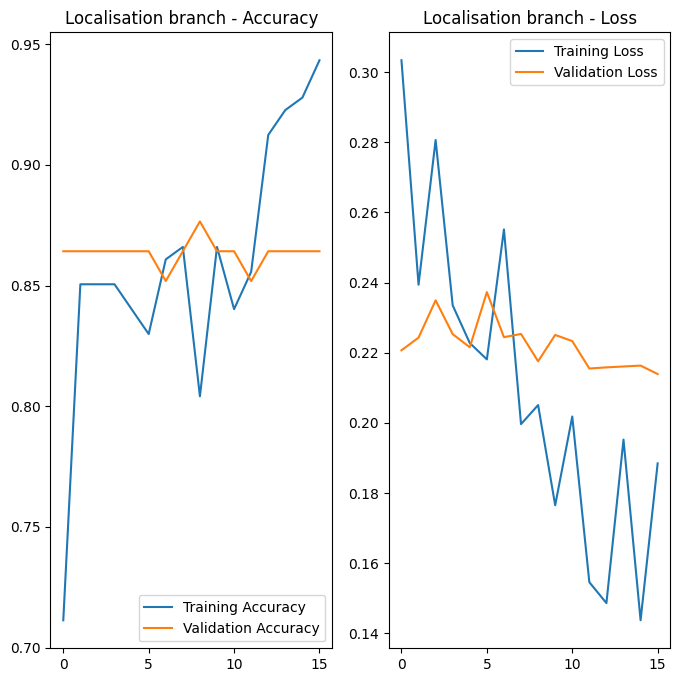

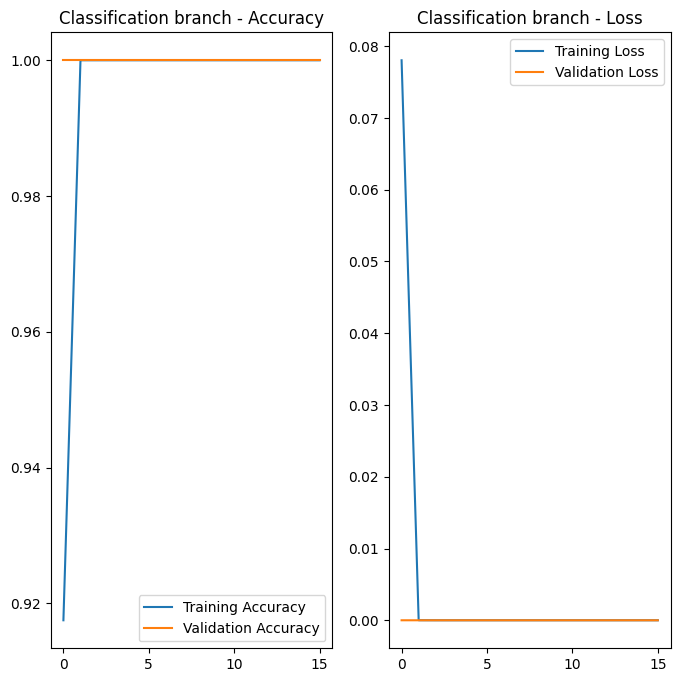

In [22]:
cl_accuracy = history.history['cl_head_accuracy']
cl_val_acc = history.history['val_cl_head_accuracy']

bb_accuracy = history.history['bb_head_accuracy']
bb_val_acc = history.history['val_bb_head_accuracy']

cl_loss = history.history['cl_head_loss']
cl_val_loss = history.history['val_cl_head_loss']

bb_loss = history.history['bb_head_loss']
bb_val_loss = history.history['val_bb_head_loss']



epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, bb_accuracy, label='Training Accuracy')
plt.plot(epochs_range, bb_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Localisation branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, bb_loss, label='Training Loss')
plt.plot(epochs_range, bb_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Localisation branch - Loss')
plt.show()

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, cl_accuracy, label='Training Accuracy')
plt.plot(epochs_range, cl_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Classification branch - Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, cl_loss, label='Training Loss')
plt.plot(epochs_range, cl_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Classification branch - Loss')
plt.show()

In [59]:
found_test_images

[('kangaroo-254.jpg', 2000, 1125),
 ('kangaroo-543.jpg', 3001, 2000),
 ('kangaroo-189.jpg', 1068, 712),
 ('kangaroo-567.jpg', 1024, 576),
 ('kangaroo-687.jpg', 1200, 900),
 ('kangaroo-248.jpg', 2048, 1368),
 ('kangaroo-615.jpg', 976, 549),
 ('kangaroo-240.jpg', 371, 136),
 ('kangaroo-177.jpg', 2560, 1246),
 ('kangaroo-251.jpg', 275, 183),
 ('kangaroo-115.jpg', 976, 790),
 ('kangaroo-672.jpg', 2048, 1365),
 ('kangaroo-197.jpg', 1200, 900),
 ('kangaroo-110.jpg', 800, 600),
 ('kangaroo-62.jpg', 1200, 800),
 ('kangaroo-442.jpg', 267, 189),
 ('kangaroo-698.jpg', 1098, 1440),
 ('kangaroo-9.jpg', 2392, 3638),
 ('kangaroo-47.jpg', 1024, 576),
 ('kangaroo-389.jpg', 615, 824),
 ('kangaroo-650.jpg', 1024, 683),
 ('kangaroo-523.jpg', 1024, 771),
 ('kangaroo-344.jpg', 928, 529),
 ('kangaroo-146.jpg', 3200, 1791),
 ('kangaroo-164.jpg', 1046, 698),
 ('kangaroo-553.jpg', 1300, 610),
 ('kangaroo-513.jpg', 1024, 576),
 ('kangaroo-245.jpg', 1046, 698),
 ('kangaroo-294.jpg', 275, 183),
 ('kangaroo-262.jpg

In [80]:
image_name = 'kangaroo-371.jpg'
validation_img = 'data/images/' + image_name

# Image Resizing
img = keras.preprocessing.image.load_img(validation_img, target_size=(600, 600))

# Image to Array for Processing
img = keras.preprocessing.image.img_to_array(img)

img = tf.expand_dims(img, 0)

# Model Predicting Validation Image
predictions = model.predict(img)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


[array([[-17.935865,  12.837388]], dtype=float32),
 array([[0.08347413, 0.09134736, 0.25618353, 0.5661394 ]], dtype=float32)]

In [90]:
normalized_bounding_boxes = predictions[1]
normalized_bounding_boxes[0].tolist()

[0.08347412943840027,
 0.0913473591208458,
 0.25618353486061096,
 0.5661394000053406]

In [83]:
filtered_image_details = [x for x in found_test_images if x[0] == image_name]
filtered_image_details

[('kangaroo-371.jpg', 1046, 698)]

In [86]:
val_index = found_test_images.index(filtered_image_details[0])
val_index

76

In [95]:
details = filtered_image_details[0]

bounding_boxes = []

w = details[1]
h = details[2]
xmin, ymin, xmax, ymax = normalized_bounding_boxes[0].tolist()

x1 = round(xmin * h, 2)
y1 = round(ymin * w, 2)
x2 = round(xmax * h, 2)
y2 = round(ymax * w, 2)

bounding_boxes = [x1, y1, x2, y2]
bounding_boxes

[58.26, 95.55, 178.82, 592.18]

In [100]:
v_xmin, v_ymin, v_xmax, v_ymax = list(validation_targets[3])

v_x1 = round(v_xmin * w, 2)
v_y1 = round(v_ymin * h, 2)
v_x2 = round(v_xmax * w, 2)
v_y2 = round(v_ymax * h, 2)


val_bounding_box = [v_x1, v_y1, v_x2, v_y2]
val_bounding_box

[np.float64(0.6), np.float64(117.39), np.float64(404.01), np.float64(624.84)]

In [97]:
from PIL import Image, ImageDraw

In [98]:
validation_targets[0]

array([1.50000000e-04, 3.88740741e-02, 1.83300000e-01, 5.33333333e-01])

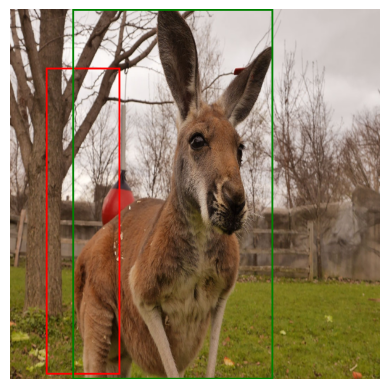

In [99]:
bounded_image = Image.open(validation_img)
bounded_image = cv2.resize(np.array(bounded_image), target_size)

bounded_image = Image.fromarray(bounded_image)

draw = ImageDraw.Draw(bounded_image)

draw.rectangle(bounding_boxes, outline='red', width=3)
draw.rectangle(val_bounding_box, outline='green', width=3)

plt.imshow(bounded_image)
plt.axis('off')
plt.show()